# Toy Model image regression exercise

This is an extension of the previous toy model, but we willl try to predict the phase of the bunch given only image data.



# Toy Accelerator Model (Copy)

Simple longitudinal phase space example, mapping particles through a linac and then an arc. 

Produces longitudinal phase space screens for various linac phases. 


In [2]:
import numpy as np

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import cos, pi, sqrt

c_light = 299792458.


Make a bunch in $(z, \delta)$ space at reference energy $E_0$, where $z=-ct$ and the relative energy spread $\delta = (E-E_0)/E_0$.

In [3]:
# Simple bunch in longitudinal phase space

# z = - c t
sigma_z = 0.001; # units: meters
# delta = (E-E0)/ E0 relative energy spread
sigma_delta= .0001; # units: 1

nparticles = 1000;

# Gussian Distribution initial bunch
dist_mean = [0,0]
dist_covariance =  [[sigma_z**2, 0], [0, sigma_delta**2]]

def init_bunch(n_particles):
  return np.random.multivariate_normal(dist_mean,dist_covariance, n_particles);
bunch0 = init_bunch(nparticles)



# Bunch data
bunch0

array([[ 4.42513556e-04, -8.26250585e-05],
       [-5.59616146e-04,  8.86435628e-05],
       [ 1.61279199e-03, -1.04912634e-04],
       ...,
       [ 1.17054431e-04, -1.21346262e-05],
       [-5.95743347e-06, -1.00951364e-04],
       [ 7.98230921e-05, -2.88401144e-05]])

In [4]:
# Some statistics
def bunch_stats(bunch):
  stats = {}
  stats['z_min'], stats['delta_min'] = np.amin(bunch, 0)
  stats['z_max'], stats['delta_max'] = np.amax(bunch, 0)
  stats['sigma_z'], stats['sigma_delta'] = list(map(sqrt, np.var(bunch, 0)))
  
  return stats

bunch_stats(bunch0)

{'z_min': -0.002955447896417292,
 'delta_min': -0.0003022103104597362,
 'z_max': 0.002783730402054074,
 'delta_max': 0.00044824569880651043,
 'sigma_z': 0.0010002540733200684,
 'sigma_delta': 9.980589007279822e-05}

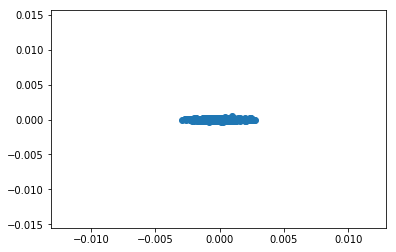

In [5]:
# Simple plot. 
plt.scatter(*bunch0.T)
plt.show()

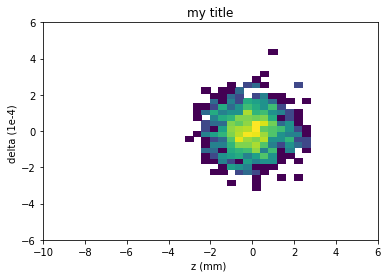

In [6]:
# Better plot

def plot_bunch(bunch, title=None, range=[(-6,6), (-6,6)]):
  x,y =bunch.T
  # colab limitations:
  #   This looks nicer on a local machine
  #   tex doesn't work: plt.rc('text', usetex=True)
  #   plt.xlabel(r'\textbf{time} (s)')
  
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xlabel('z (mm) ')
  ax.set_ylabel('delta (1e-4) ')
  if title: ax.set_title(title)
    
  ax.hist2d(1e3*x, 1e4*y, bins=40, norm=LogNorm(), range=range );
  #plt.colorbar()  
 
  return fig

  
plot_bunch(bunch0, title='my title', range=[(-10,6), (-6,6)]);

Simple Cavity map. Acceleration from energy $E_0$ to $E_1$ through a cavity with phase $\phi$, frequency $f$, and $k=2\pi f/c$.

$z \rightarrow z \\ 
\delta \rightarrow \delta \frac{E_0}{E_1} + (1- \frac{E_0}{E_1})\frac{\cos(kz +\phi)}{\cos(\phi)}$

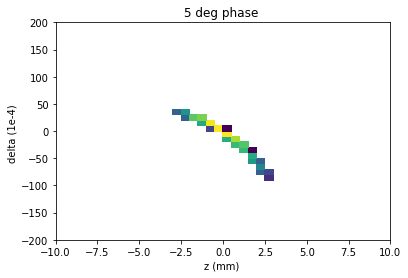

In [7]:
# Accelerate through a linac

def linac(bunch, energy0=100e6, energy1=1000e6, frf=1.3e9, phi=2*pi*(0/360)):
  """
  Simple linac (cavity) map. Accelerates from energy0 to energy1, with rf frequency frf (Hz) and phase phi (rad). 
  """
  k = 2*pi*frf/c_light
  return np.array([ (z, (1-energy0/energy1)*(cos(k*z+phi)/cos(phi) -1)+ energy0/energy1 *delta) for (z,delta) in bunch])
  

bunch1 = linac(bunch0, phi=2*pi*(5/360))
plot_bunch(bunch1, title = '5 deg phase ', range=[(-10,10), (-200,200)]);

Simple longitudinal arc map, parameterized by $r_{56}$ and $t_{566}$:

$z \rightarrow z + r_{56}\,\delta + t_{566}\,\delta^2 \\ 
\delta \rightarrow \delta$

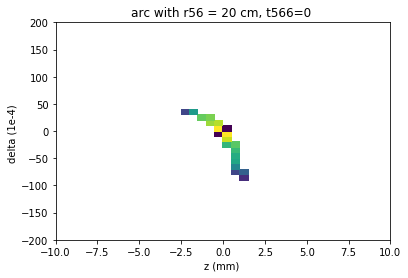

In [8]:
# Transport through an arc

def arc(bunch, r56=0, t566=0):
  """
  Simple arc with transport terms r56 and t566
  z -> z + r56*delta + t566*delta**2
  delta -> delta
  """
  return np.array([(z + r56*delta + t566*delta**2, delta) for (z, delta) in bunch])
 
bunch2 = arc(bunch1, r56 = 20e-2, t566 = 0)

plot_bunch(bunch2, title = 'arc with r56 = 20 cm, t566=0 ', range=[(-10,10), (-200,200)]);

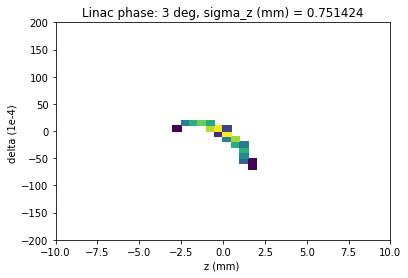

In [9]:

def my_accelerator(phase_deg):
  bunch1 = linac(bunch0, phi=2*pi*(phase_deg/360))
  bunch2 = arc(bunch1, r56 = 20e-2, t566 = 1)
  
  stats = bunch_stats(bunch2)
  sigz = '{:f}'.format(1000*stats['sigma_z'])
  
  title = 'Linac phase: '+str(phase_deg)+' deg, sigma_z (mm) = '+sigz
  fig = plot_bunch(bunch2, title=title, range=[(-10,10), (-200,200)])
  
  return fig
  
  #plt.ylabel('counts')
  #plt.hist(1000*bunch2.T[0], bins = 100, range=(-5,5))
my_accelerator(3);

# Make data similiar to MNIST format



In [10]:
# Histogram 2d

BIN_RANGE = [(-10,10), (-200,200)]

def bin_bunch(bunch, bins=(28,28), range=BIN_RANGE ):
  x,y =bunch.T
  xedges = range
  H, xedges, yedges = np.histogram2d( 1e3*x, -1e4*y, normed=True, bins=bins, range=range )
 
  return H

# Binned plot

def plot_binned_bunch(bbunch, title=None, range=[(-6,6), (-6,6)]):
  
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xlabel('z (mm) ')
  ax.set_ylabel('delta (1e-4) ')
  if title: ax.set_title(title)
    
  ax.imshow(bbunch.T, extent=(range[0][0], range[0][1], range[1][0], range[1][1]), aspect='auto')
  #plt.colorbar()  
 
  return fig
binnedbunch0 = bin_bunch(bunch2);

# Partial data
binnedbunch0[10:20,10:20]


array([[0.0000e+00, 9.8000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 2.0580e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 1.0780e-03, 1.1074e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 8.8200e-03, 2.7146e-02, 9.8000e-05,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.8000e-05, 2.3912e-02,
        1.2152e-02, 4.8020e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.9000e-04, 3.9200e-03, 1.4700e-03, 7.8400e-04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+0

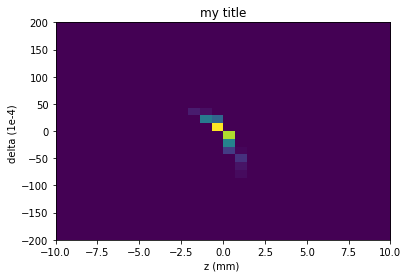

In [11]:
# Plot of binned bunch
plot_binned_bunch(binnedbunch0, range=BIN_RANGE, title='my title');

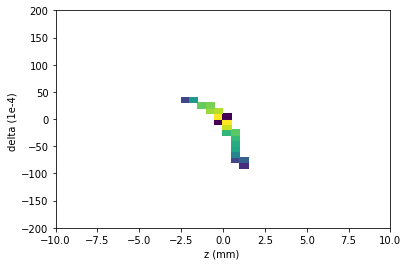

In [12]:
# Previous plotting function
plot_bunch(bunch2, range=BIN_RANGE);

In [13]:

# Make binned bunch (screen) data, with noise
def binned_accelerator(phase_deg, noise=0):
  bunch0 = init_bunch(100)
  bunch1 = linac(bunch0, phi=2*pi*(phase_deg/360))
  bunch2 = arc(bunch1, r56 = 20e-2, t566 = 1)
  
  bbunch = bin_bunch(bunch2) 
  
  if noise > 0:
    bbunch = bbunch + np.random.rand( bbunch.shape[0],bbunch.shape[1])*noise
  
  return bbunch

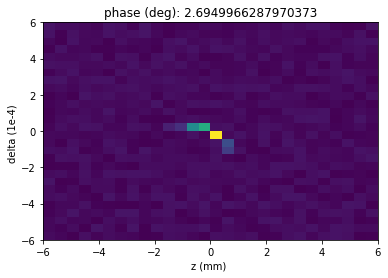

In [14]:
def make_data1(): 
  phase_deg = (np.random.rand() - 0.5)*20 # +/- 10 deg phases
  label = phase_deg 
  data = binned_accelerator(phase_deg, noise=0.002)
  return data, label

bbunch1, label1 = make_data1();
plot_binned_bunch(bbunch1, title = "phase (deg): "+str(label1));

In [20]:
def make_data(n):
  data = np.empty([n, 28,28])
  labels = np.empty([n])
  for i in range(n):
    data[i], labels[i] =  make_data1()
  return data, labels
x_train, y_train = make_data(80000);
x_train.shape, y_train.shape

((80000, 28, 28), (80000,))

In [21]:
# Check the range of the labels
min(y_train), max(y_train)

(-9.999733933108889, 9.999962294414226)

In [22]:
# MNIST style dataset
n_train, n_val, n_test = 60000, 10000, 10000;
x_train0, y_train0 = make_data(n_train);
x_test0, y_test0 =  make_data(n_test);
x_val0, y_val0 =  make_data(n_val);
x_train0.shape

(60000, 28, 28)

# Exercise: try to predict the phase given an image (array of pixel values) with a Convolutional Neural Network


In [17]:
# Your code here

# Example solution with Keras (and Tensorflow backend). Try to do better!

In [18]:
# https://keras.io/
#!pip install -q keras
#import keras

//anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

In [25]:
# Reshape
x_train = x_train0.reshape(x_train0.shape[0], img_rows, img_cols, 1)
x_test  = x_test0.reshape(x_test0.shape[0], img_rows, img_cols, 1)
x_val  = x_val0.reshape(x_val0.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'val samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
10000 val samples


In [27]:
# Scale labels from [-10,10] -> [0,1]
y_train = (y_train0/10 +1)/2.0
y_test  = (y_test0/10  +1)/2.0
y_val  = (y_val0/10  +1)/2.0

# Make model
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(16))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

In [34]:
n_train = 60000;
history2 = model2.fit(x_train[:n_train], y_train[:n_train],
          batch_size=2*batch_size,
          epochs=5,
          verbose=1,
          validation_data=(x_val, y_val))
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 401s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0542 - val_loss: 0.0011 - val_mean_absolute_error: 0.0225
Epoch 2/5
60000/60000 [==============================] - 400s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0531 - val_loss: 0.0014 - val_mean_absolute_error: 0.0274
Epoch 3/5
60000/60000 [==============================] - 401s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0521 - val_loss: 0.0013 - val_mean_absolute_error: 0.0272
Epoch 4/5
60000/60000 [==============================] - 405s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0511 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 5/5
60000/60000 [==============================] - 406s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0506 - val_loss: 9.6428e-04 - val_mean_absolute_error: 0.0226
Test loss: 0.0009819937878288328
Test accuracy: 0.022783473441004752


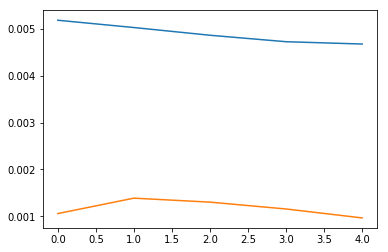

In [39]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

In [36]:
# Spot check

n_sample = 32;
x_sample, y_sample = make_data(n_sample);
x_sample= x_sample.reshape(x_sample.shape[0], img_rows, img_cols, 1)

predictions = model2.predict(x_sample)
# Where the error in this set is:
iworst = abs(predictions[:,0]*10 - y_sample).argmax()

predict phase (deg):  1.1565089225769043
actual phase (deg):  -8.863601292193069


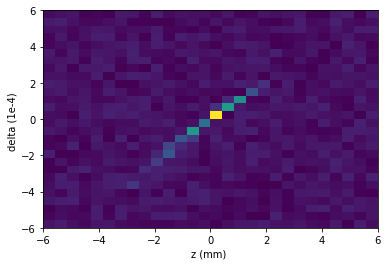

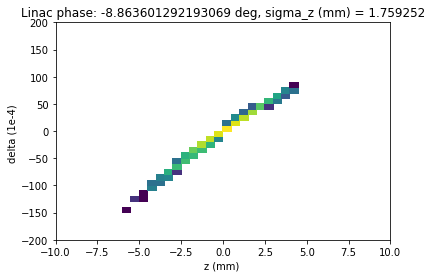

In [37]:
ii=iworst
phase_predict = predictions[ii,0]*10
phase_actual = y_sample[ii]
print("predict phase (deg): ", phase_predict)
print('actual phase (deg): ',  phase_actual)
plot_binned_bunch(x_sample[ii].reshape(28,28));
my_accelerator(phase_actual);

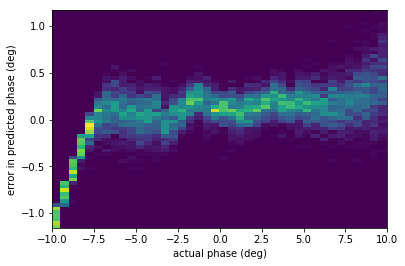

In [38]:
# Errors vs actual phase
plt.xlabel('actual phase (deg)')
plt.ylabel('error in predicted phase (deg)')
#x_here = x_train;
#y_here = y_train;
x_here = x_test;
y_here = y_test;
plt.hist2d( y_here*20-10,  (y_here- model2.predict(x_here)[:,0])*10, bins=(40,60));